# Shadow Area Filling Stage

In this notebook we will be completing the second half of the Shadow Generation for Composite Image in Real-World Scenes paper. 

This half consists of using the generated Shadow masks from the previous half in order to fill in the predicted area on Ic to create a new image with full shadows.

Steps:
1. Precompute shadow parameters before training using linear regression
2. Create Ep to estimate shadow parameters
3. Make Ic dark
4. Create encoder Em and decoder Dm to finish Gm generator
5. Generate alpha matte
6. Use alpha matte and Ic dark to make Ig~
7. Use the conditional discriminator D for optimization

## Setup

Initialize cuda and import libraries. In this project we will be using PyTorch.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torch.nn.init as init

import torchvision.datasets as dset
import torchvision.transforms as T
import torchvision.utils as vutils

from PIL import Image
import os
import random

import numpy as np
import matplotlib.pyplot as plt
import cv2
import math

%load_ext autoreload
%autoreload 2

# setup
device = None

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print('using device:', device)

using device: cuda


## Dataloader

The data we are going to use are the shadow prediction masks we made in the previous half of the work.

In [2]:
def numerical_sort(path):
    return int(os.path.basename(path)[:-4])

In [3]:
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, root_dir, sort=None, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.imgs = os.listdir(root_dir)
        self.sort = sort
        if self.sort is not None:
            self.image_paths = sorted(os.listdir(root_dir), key=numerical_sort)
    
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, idx):
        if self.sort is not None:
            img_path = os.path.join(self.root_dir, self.image_paths[idx])
        else:
            img_path = os.path.join(self.root_dir, self.imgs[idx])
        image = Image.open(img_path).convert("RGB")  # Convert to color
        
        if self.transform is not None:
            image = self.transform(image)

        return image

transform = T.Compose([T.ToTensor()]) # can add more if necessary
    
# Batch size during training
batch_size = 1

path_train = 'DESOBA_DATASET/TrainTestVisualization/train'
path_test = 'DESOBA_DATASET/TrainTestVisualization/test_bos'

path_mask_test = 'DESOBA_DATASET/Mfs_test'
path_mask_train = 'DESOBA_DATASET/Mfs_train'

dataset = CustomDataset(path_train, transform=transform)
dataset_test = CustomDataset(path_test, transform=transform)
dataset_mask_train = CustomDataset(path_mask_train, sort=True, transform=transform)
dataset_mask_test = CustomDataset(path_mask_test, sort=True, transform=transform)


# Create the dataloaders
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size) # training images
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size) # testing images
dataloader_mask_train = torch.utils.data.DataLoader(dataset_mask_train,\
                                                    batch_size=batch_size, shuffle=False) # mask training image
dataloader_mask_test = torch.utils.data.DataLoader(dataset_mask_test,\
                                                   batch_size=batch_size, shuffle=False) # mask testing image


# size of my training set
dataset_size = dataset.__len__() # size to test
dataset_test_size = dataset_test.__len__() # size to test

print(dataset_size)
print(dataset_test_size)
print(dataset_mask_train.__len__()) # only kept 1000 for sake of time
print(dataset_mask_test.__len__())

11509
581
1000
581


## Input Handling Function

This step is necessary to separate the Ic, Mbos, Mfo from the training/testing image pairs. The input to the foreground encoder needs the composite image Ic, and the foreground object mask Mfo. The input to the background encoder is Ic, and the background object and shadow mask Mbos.

In order to get Ic and Mbos, Mfo, we need to consider the length of the training image itself. Each image section is 256x256 pixels in length with a total training image size of 1536 pixels. This means that there are 6 sections in each training image. The first 256x256 pixels correspond to Ic, the second section corresponds to the original image, the third is Mfo, the fourth corresponds to the mask of the foreground object shadow as ground truth, the fifth is Mbos, and the sixth is the mask of the background object shadow.

In the input_sectioning function we will be extracting all the parts from each training image to use individually in the training loop. The foreground Encoder requires Mfo and Ic, and the background encoder requires Mbos and Ic.

In [4]:
# input management
def input_sectioning(whole_image):
    original_image = whole_image[:, 256:512]
    Ic = whole_image[:, 0:256] # composite image
    Mfo = whole_image[:, 512:768] # foreground object mask
    Mfo_shadow = whole_image[:, 768:1024] # foreground object shadow mask for ground truth    
    
    Mbo = whole_image[:, 1024:1280] # background object mask
    Mbo_shadow = whole_image[:, 1280:1536] # background object shadow mask
    Mbos = Mbo + Mbo_shadow # background object-shadow pair
    
    # changing the images to be 256x256x1
    # Take the maximum along the channel dimension to collapse it to a single channel
    Mbos = torch.max(Mbos, dim=2)[0]
    Mfo = torch.max(Mfo, dim=2)[0]
    Mfo_shadow = torch.max(Mfo_shadow, dim=2)[0]

    # Reshape the tensor to have the shape 256x256x1
    Mbos = Mbos.unsqueeze(dim=2)
    Mfo = Mfo.unsqueeze(dim=2)
    Mfo_shadow = Mfo_shadow.unsqueeze(dim=2)

    return original_image, Ic, Mfo, Mbos, Mfo_shadow

## Weight Initialization Function

In [5]:
# custom weights initialization called on encoders, to test various weight initializations

def weights_init(net, init_type='normal', gain=0.02):
    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
            if init_type == 'normal':
                init.normal_(m.weight.data, 0.0, gain)
            elif init_type == 'xavier':
                init.xavier_normal_(m.weight.data, gain=gain)
            elif init_type == 'kaiming':
                init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            elif init_type == 'orthogonal':
                init.orthogonal_(m.weight.data, gain=gain)
            else:
                raise NotImplementedError('initialization method [%s] is not implemented' % init_type)
            if hasattr(m, 'bias') and m.bias is not None:
                init.constant_(m.bias.data, 0.0)
        elif classname.find('BatchNorm2d') != -1:
            init.normal_(m.weight.data, 1.0, gain)
            init.constant_(m.bias.data, 0.0)

    #print('initialize network with %s' % init_type)
    net.apply(init_func)

## Flatten Function

In [6]:
def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

## Save/Load Parameters Function

In [16]:
# Save the shadow parameters list to a file using pickle
def save_shadow_parameters_to_file(filename, shadow_parameters_list):
    with open(filename, 'wb') as f:
        pickle.dump(shadow_parameters_list, f)
        
# Load the shadow parameters list from a file using pickle
def load_shadow_parameters_from_file(filename):
    with open(filename, 'rb') as f:
        shadow_parameters_list = pickle.load(f)
    return shadow_parameters_list

def load_shadow_parameters():
    return load_shadow_parameters_from_file('shadow_parameters.pkl')

# Save the predicted parameters list to a file using pickle
def save_predicted_parameters_to_file(filename, predicted_parameters_list):
    with open(filename, 'wb') as f:
        pickle.dump(predicted_parameters_list, f)
        
# Load the predicted parameters list from a file using pickle
def load_predicted_parameters_from_file(filename):
    with open(filename, 'rb') as f:
        predicted_parameters_list = pickle.load(f)
    return predicted_parameters_list

def load_predicted_parameters():
    return load_predicted_parameters_from_file('predicted_shadow_parameters.pkl')

# Part 1: Precompute the Ground Truth Shadow Parameters

In this section we will compute the ground truth shadow parameters w_dark and b_dark using linear regression. These will then be used to estimate the testing shadow parameters which are estimated by Ep. We will be limiting ourselves to 1000 parameters for the sake of time.

In [8]:
from sklearn.linear_model import LinearRegression

def extract_features(original_img, composite_img, foreground_shadow_mask):
    
    foreground_shadow_mask = foreground_shadow_mask.bool()
    foreground_shadow_mask = foreground_shadow_mask.squeeze()
    
    # Extract the pixel values from the composite image in the foreground shadow area
    composite_img_R = composite_img[:, :, 0]
    composite_img_G = composite_img[:, :, 1]
    composite_img_B = composite_img[:, :, 2]
    
    Xr = composite_img_R[foreground_shadow_mask]
    Xb = composite_img_G[foreground_shadow_mask]
    Xg = composite_img_B[foreground_shadow_mask]

    # Extract the corresponding pixel values from the original image in the foreground shadow area
    original_img_R = composite_img[:, :, 0]
    original_img_G = composite_img[:, :, 1]
    original_img_B = composite_img[:, :, 2]
    
    Yr = original_img_R[foreground_shadow_mask]
    Yg = original_img_G[foreground_shadow_mask]
    Yb = original_img_B[foreground_shadow_mask]

    return Xr, Xg, Xb, Yr, Yg, Yb

def find_shadow_parameters(X, Y):
    # Create a linear regression model
    model = nn.Linear(1, 1)  # We use 1 input feature and 1 output feature for simplicity

    # Define the loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01)

    # Training loop
    num_epochs = 50
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        output = model(X.reshape(-1, 1))
        loss = criterion(output, Y.reshape(-1, 1))
        loss.backward()
        optimizer.step()

    # Get the optimal regression coefficients (w_dark, b_dark)
    w_dark = model.weight.item()
    b_dark = model.bias.item()

    return w_dark, b_dark

def get_shadow_parameters():
    shadow_parameters_list = []
    # goes through training data
    for i, data in enumerate(dataloader, 0): 
        if i == 1000:
            break
        object_pair = data[0].permute(1, 2, 0)
        original_img, Ic, Mfo, Mbos, Mfo_shadow = input_sectioning(object_pair)
        
        Xr, Xg, Xb, Yr, Yg, Yb = extract_features(original_img, Ic, Mfo_shadow)
        
        w_dark_r, b_dark_r = find_shadow_parameters(Xr, Yr)
        w_dark_g, b_dark_g = find_shadow_parameters(Xg, Yg)
        w_dark_b, b_dark_b = find_shadow_parameters(Xb, Yb)

        shadow_parameters_list.append([w_dark_r, w_dark_b, w_dark_g, b_dark_r, b_dark_g, b_dark_g])
        
    # goes through test data
    for i, data in enumerate(dataloader_test, 0): 
        if i == 1000:
            break
        object_pair = data[0].permute(1, 2, 0)
        original_img, Ic, Mfo, Mbos, Mfo_shadow = input_sectioning(object_pair)
        
        Xr, Xg, Xb, Yr, Yg, Yb = extract_features(original_img, Ic, Mfo_shadow)
        
        w_dark_r, b_dark_r = find_shadow_parameters(Xr, Yr)
        w_dark_g, b_dark_g = find_shadow_parameters(Xg, Yg)
        w_dark_b, b_dark_b = find_shadow_parameters(Xb, Yb)
        
        shadow_parameters_list.append([w_dark_r, w_dark_b, w_dark_g, b_dark_r, b_dark_g, b_dark_g])
    
    return shadow_parameters_list


In [9]:
'''
The shadow parameters are stored in this format [w,b]. These represent the ground truth parameters.
The first 1000 are from the training data and the rest are from the testing data.
'''
shadow_parameters_list = get_shadow_parameters() 

In [10]:
print(shadow_parameters_list[0])

[-0.14853310585021973, -0.8068510890007019, 0.6921922564506531, 0.3840183913707733, 0.23024554550647736, 0.23024554550647736]


In [17]:
import pickle

#save_parameters_to_file('shadow_parameters.pkl', shadow_parameters_list)
test = load_shadow_parameters()
print(test[0])

[0.6982265710830688, 1.0481832027435303, 0.05540766939520836, 0.3738528788089752, 0.426186203956604, 0.426186203956604]


# Part 2: Create Ep

Ep is an encoder that takes Ic and Mfs (foreground shadow mask) as inputs and outputs the shadow parameters w_dark and b_dark. The loss function of the Ep training will be using the ground truth that is precomputed using linear regression before the training.

In [11]:
# Shared downsampling block
class DBlkp(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv(x)
        x = self.relu(x)
        x = self.max_pool(x)
        return x

# Foreground encoder (parameter sharing)
class EncoderP(nn.Module):
    def __init__(self):
        super().__init__() # input is 256x256x32
        # Shared downsampling blocks
        self.down_block1 = DBlkp(in_channels=4, out_channels=32)
        self.down_block2 = DBlkp(in_channels=32, out_channels=64)
        self.down_block3 = DBlkp(in_channels=64, out_channels=128)
        self.down_block4 = DBlkp(in_channels=128, out_channels=256)
        self.gap = nn.AdaptiveAvgPool2d((1, 1))  # Output size will be 1x1
        self.fc = nn.Linear(256, 6)
        
    def forward(self, x):
        skip1 = self.down_block1(x)
        skip2 = self.down_block2(skip1)
        skip3 = self.down_block3(skip2)
        x = self.down_block4(skip3)
        x = self.gap(x)
        x = flatten(x)
        x = self.fc(x)
        
        return x

In [12]:
# testing model for output size
data = torch.randn((1,4,256,256)).to(device)
u = EncoderP().to(device)
out = u(data)
print(out.shape)

torch.Size([1, 6])


/opt/conda/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


## Initialize the Ep Model

In [13]:
# initializing model
Ep = EncoderP().to(device)
Ep.apply(weights_init)

EncoderP(
  (down_block1): DBlkp(
    (conv): Conv2d(4, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU(inplace=True)
    (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (down_block2): DBlkp(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU(inplace=True)
    (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (down_block3): DBlkp(
    (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU(inplace=True)
    (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (down_block4): DBlkp(
    (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU(inplace=True)
    (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (gap): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=25

# Part 3: Train Ep

In this section we train the shadow parameter predictor Ep. This encoder will predict the shadow parameters for the mask that we created in the previous stage.

In [22]:
mask_train_list = list(dataloader_mask_train)
mask_test_list = list(dataloader_mask_test)

In [55]:
beta1 = 0.5
beta2 = 0.99
model_path = 'models/Ep.pth'

def train_encoder(model, dataloader, dataloader_test, mask_train_list, mask_test_list,\
                  ground_truth, epochs=1, learning_rate=0.0002):
    total_train_steps = len(mask_train_list)
    total_test_steps = len(mask_test_list)
    predicted_shadow_parameters = []
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(Ep.parameters(), lr=learning_rate, betas=(beta1, beta2))
    
    # Start the training cycle
    print('Start training...')

    for epoch in range(epochs):
        model.train()  # put model to training mode
        training_loss = 0.0
        for i, data in enumerate(dataloader, 0): 
            if i == 1000:
                break
            
            ### fixing input size and shape
            object_pair = data[0].permute(1, 2, 0)
            original_img, Ic, Mfo, Mbos, Mfo_shadow = input_sectioning(object_pair)
            
            # fix the shapes for concatenation
            Mfs_pred = torch.mean(mask_train_list[i], dim=1, keepdim=True)
            Ic = Ic.permute(2, 0, 1).unsqueeze(0)
            
            # concatenate Ic and Mfo and Ic and Mbos
            inputs = torch.cat([Ic, Mfs_pred], dim=1).to(device) # 1x4x256x256
            
            optimizer.zero_grad()
            predicted_params = Ep(inputs)
            
            predicted_shadow_parameters.append(predicted_params)
            ground_truth[i] = torch.tensor(ground_truth[i]).to(device)
            
            loss = criterion(predicted_params, ground_truth[i])
            loss.backward()
            optimizer.step()
            
            # Output training stats
            if i % 100 == 0:
                print('[%d/%d]\tTraining Loss: %.4f'
                      % (epoch, epochs, loss.item()))
                
            training_loss += loss.item()
        
        # Put the model in eval mode
        model.eval()
        testing_loss = 0.0
        for j, data in enumerate(dataloader_test, 0): 
            
            ### fixing input size and shape
            object_pair = data[0].permute(1, 2, 0)
            original_img, Ic, Mfo, Mbos, Mfo_shadow = input_sectioning(object_pair)
            
            # fix the shapes for concatenation
            Mfs_pred = torch.mean(mask_test_list[j], dim=1, keepdim=True)
            Ic = Ic.permute(2, 0, 1).unsqueeze(0)
            
            # concatenate Ic and Mfo and Ic and Mbos
            inputs = torch.cat([Ic, Mfs_pred], dim=1).to(device) # 1x4x256x256
            ground_truth[i+j] = torch.tensor(ground_truth[i+j]).to(device)
            
            with torch.no_grad():
                predicted_params = Ep(inputs)
            
            predicted_shadow_parameters.append(predicted_params)

            loss = criterion(predicted_params, ground_truth[i+j])
            
            # Output training stats
            if j % 50 == 0:
                print('[%d/%d]\tTraining Loss: %.4f'
                      % (epoch, epochs, loss.item()))
                
            testing_loss += loss.item()
            
        # Save last epoch model
        if epoch == epochs-1:
            torch.save(model.state_dict(), model_path)
            print('Model saved!')
        
        train_loss = training_loss / total_train_steps
        test_loss = testing_loss / total_test_steps
        
        print(f'\nEpoch {epoch}, train_loss: {train_loss}, test_loss: {test_loss}')
           
    return predicted_shadow_parameters, training_loss, testing_loss
            

In [56]:
predicted_shadow_parameters, training_loss, testing_loss = \
train_encoder(Ep, dataloader, dataloader_test, mask_train_list, mask_test_list,\
              shadow_parameters_list, epochs=1, learning_rate=0.0002)

Start training...
[0/1]	Training Loss: 0.2298


/tmp/ipykernel_121591/1461049439.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ground_truth[i] = torch.tensor(ground_truth[i]).to(device)


[0/1]	Training Loss: 0.2523
[0/1]	Training Loss: 0.1563
[0/1]	Training Loss: 0.0708
[0/1]	Training Loss: 0.1458
[0/1]	Training Loss: 0.3096
[0/1]	Training Loss: 0.0304
[0/1]	Training Loss: 0.1152
[0/1]	Training Loss: 0.1980
[0/1]	Training Loss: 0.3648


/tmp/ipykernel_121591/1461049439.py:67: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ground_truth[i+j] = torch.tensor(ground_truth[i+j]).to(device)


[0/1]	Training Loss: 0.2533
[0/1]	Training Loss: 0.2623
[0/1]	Training Loss: 0.2264
[0/1]	Training Loss: 0.1313
[0/1]	Training Loss: 0.1127
[0/1]	Training Loss: 0.2846
[0/1]	Training Loss: 0.2361
[0/1]	Training Loss: 0.2753
[0/1]	Training Loss: 0.3478
[0/1]	Training Loss: 0.1249
[0/1]	Training Loss: 0.4159
[0/1]	Training Loss: 0.3538
Model saved!

Epoch 0, train_loss: 0.18383824965963141, test_loss: 0.17958422795758805


In [61]:
save_predicted_parameters_to_file('predicted_shadow_parameters.pkl', predicted_shadow_parameters)
print(len(predicted_shadow_parameters))
print(predicted_shadow_parameters[0])

1581
tensor([[0.1520, 0.1699, 0.1297, 0.2520, 0.2443, 0.2438]], device='cuda:0',
       grad_fn=<AddmmBackward>)


In [62]:
#predicted_shadow_parameters = load_predicted_parameters()
#print(predicted_shadow_parameters[0])

# Part 5: Create Ic_dark

Here we will use our estimated w_dark, and b_dark to find Ic_dark using Eqn.8 from the paper. This equation is: 

w_dark(Ic) + b_dark

Then we are going to save Ic_dark to the path DESOBA_DATASET/Ic_dark.

In [63]:
def get_ic_dark(Ic, shadow_parameters):
    # save each parameter independently
    w_dark_r, w_dark_g, w_dark_b, b_dark_r, b_dark_g, b_dark_b = shadow_parameters.squeeze().tolist()
    
    # splic Ic into its composing matrices
    Ic_R = Ic[:, :, 0]
    Ic_G = Ic[:, :, 1]
    Ic_B = Ic[:, :, 2]
    
    # w_dark * Ic + b_dark
    Ic_dark_r = (w_dark_r * Ic_R) + b_dark_r
    Ic_dark_g = (w_dark_g * Ic_G) + b_dark_g
    Ic_dark_b = (w_dark_b * Ic_B) + b_dark_b
    
    # Put Ic back together and return
    Ic_dark = np.stack([Ic_dark_r, Ic_dark_g, Ic_dark_b], axis=-1)
    
    return Ic_dark

In [74]:
ic_dark_path = 'DESOBA_DATASET/Ic_dark'

for i, data in enumerate(dataloader, 0): 
    if i == 1000:
        break
            
    ### fixing input size and shape
    object_pair = data[0].permute(1, 2, 0)
    original_img, Ic, Mfo, Mbos, Mfo_shadow = input_sectioning(object_pair)
    Ic_dark = get_ic_dark(Ic, predicted_shadow_parameters[i])

    # save Ic_dark to folder
    Ic_dark_normalized = (Ic_dark * 255).astype(np.uint8)
    image = Image.fromarray(Ic_dark_normalized)
    image.save(f'DESOBA_DATASET/Ic_dark_train/{i:04d}.png')

for j, data in enumerate(dataloader_test, 0): 
    ### fixing input size and shape
    object_pair = data[0].permute(1, 2, 0)
    original_img, Ic, Mfo, Mbos, Mfo_shadow = input_sectioning(object_pair)
    
    Ic_dark = get_ic_dark(Ic, predicted_shadow_parameters[i+j])

    # save Ic_dark to folder
    Ic_dark_normalized = (Ic_dark * 255).astype(np.uint8)
    image = Image.fromarray(Ic_dark_normalized)
    image.save(f'DESOBA_DATASET/Ic_dark_test/{i:04d}.png')
  

# Part 6: Shadow Matte (alpha) Generator Gm

This generator has an encoder Em and a decoder Dm that have the same architecture as Efs and Ds. Gm is also based off of U-Net architecture except it does not have an Attention layer.

In [68]:
# Shared downsampling block
class DBlkm(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.avg_pool = nn.AvgPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.avg_pool(x)
        return x

# Encoder (parameter sharing)
class EncoderM(nn.Module): # Em
    def __init__(self):
        super().__init__() # input is 256x256x32
        # Shared downsampling blocks
        self.down_block1 = DBlkm(in_channels=32, out_channels=64)
        self.down_block2 = DBlkm(in_channels=64, out_channels=128)
        self.down_block3 = DBlkm(in_channels=128, out_channels=256)
        self.down_block4 = DBlkm(in_channels=256, out_channels=512)
        
    def forward(self, x):
        skip1 = self.down_block1(x)
        skip2 = self.down_block2(skip1)
        skip3 = self.down_block3(skip2)
        x = self.down_block4(skip3)
        
        
        return x, skip1, skip2, skip3

In [124]:
# Shared upsampling block
class UBlk(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up_conv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)
        self.conv = nn.Conv2d(out_channels+out_channels, out_channels, kernel_size=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.upsample = nn.Upsample(scale_factor=1)

    def forward(self, x, skip=None):
        x = self.up_conv(x)
        
        if skip!=None: # is not first layer
            
            # Calculate the difference in spatial dimensions between x and skip
            diff_h = x.size(2) - skip.size(2)
            diff_w = x.size(3) - skip.size(3)
            # Pad x to match the spatial dimensions of skip
            skip = F.pad(skip, (diff_w // 2, diff_w - diff_w // 2, diff_h // 2, diff_h - diff_h // 2))
            
            x = torch.cat([x,skip], dim=1)
            x = self.conv(x) # fix channel dimensions
        
        x = self.bn(x)
        x = self.relu(x)
        x = self.upsample(x)
        return x

# Decoder
class DecoderM(nn.Module): # Dm
    def __init__(self):
        super().__init__() # input is 16×16×512
        # Shared upsampling blocks
        self.up_block1 = UBlk(in_channels=512, out_channels=512)
        self.up_block2 = UBlk(in_channels=512, out_channels=256)
        self.up_block3 = UBlk(in_channels=256, out_channels=128)
        self.up_block4 = UBlk(in_channels=128, out_channels=64)        
        
    def forward(self, x, skip1, skip2, skip3):
        x = self.up_block1(x)  # No skip connection in the first layer
        x = self.up_block2(x, skip3)
        x = self.up_block3(x, skip2)
        x = self.up_block4(x, skip1) 
        
        return x     

In [130]:
# Generator Gm
class Unet(nn.Module):
    def __init__(self):
        super().__init__()
        
        # first convolution to set up input
        self.conv1 = nn.Conv2d(in_channels=7, out_channels=32, kernel_size=3, padding=1)
        
        ### Encoder
        self.em = EncoderM().to(device)
        
        ### Decoder
        self.dm = DecoderM().to(device)
        
        # last convolution to finish output
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1)
    
    def forward(self, inputs): 
        ''' 
        inputs - concatenation of Ic, Ic_dark and Mfs_predicted. Shape: 1x7x256x256
        '''
        x = self.conv1(inputs)
        
        x, skip1, skip2, skip3 = self.em(x) # foreground encoder
        x = self.dm(x, skip1, skip2, skip3) # decoder
        
        output = self.conv2(x) # foreground object shadow mask
        
        return output
        

In [131]:
# testing model for output size
data = torch.randn((1,7,256,256)).to(device)
u = Unet().to(device)
out = u(data)
print(out.shape)

torch.Size([1, 1, 256, 256])


In [132]:
# initializing model
Gm = Unet().to(device)
Gm.apply(weights_init)

Unet(
  (conv1): Conv2d(7, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (em): EncoderM(
    (down_block1): DBlkm(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (avg_pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
    )
    (down_block2): DBlkm(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (avg_pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
    )
    (down_block3): DBlkm(
      (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (avg_pool): AvgPool2d(kernel_size=2, stride=2, padding=0

# Part 7: Train Gm

## Dataloader for Ic_dark

In [90]:
import shutil
directory_to_delete = 'DESOBA_DATASET/Ic_dark_test/.ipynb_checkpoints'
if os.path.exists(directory_to_delete):
    shutil.rmtree(directory_to_delete)
    print(f"Directory '{directory_to_delete}' and its contents deleted successfully.")
else:
    print(f"Directory '{directory_to_delete}' does not exist.")

Directory 'DESOBA_DATASET/Ic_dark_test/.ipynb_checkpoints' and its contents deleted successfully.


In [91]:
path_Ic_dark_train = 'DESOBA_DATASET/Ic_dark_train'
path_Ic_dark_test = 'DESOBA_DATASET/Ic_dark_test'

dataset_Ic_dark_train = CustomDataset(path_Ic_dark_train, sort=True, transform=transform)
dataset_Ic_dark_test = CustomDataset(path_Ic_dark_test, sort=True, transform=transform)

# Create the dataloaders
dataloader_Ic_dark_train = torch.utils.data.DataLoader(dataset_Ic_dark_train,\
                                                    batch_size=batch_size, shuffle=False) # mask training image
dataloader_Ic_dark_test = torch.utils.data.DataLoader(dataset_Ic_dark_test,\
                                                   batch_size=batch_size, shuffle=False) # mask testing image

print(dataloader_Ic_dark_train.__len__())
print(dataloader_Ic_dark_test.__len__())

1000
581


In [92]:
mask_train_list = list(dataloader_mask_train)
mask_test_list = list(dataloader_mask_test)
    
ic_dark_train_list = list(dataloader_Ic_dark_train)
ic_dark_test_list = list(dataloader_Ic_dark_test)

## Loss Function and Optimizers

In [133]:
# hyperparameters for tuning
beta1 = 0.5
beta2 = 0.99
lr = 0.0002
epochs = 1

# shadow mask folder
alpha_train = 'DESOBA_DATASET/alpha_train'
alpha_test = 'DESOBA_DATASET/alpha_test'

# Initialize the ``BCELoss`` function
loss = nn.BCEWithLogitsLoss()

# Setup Adam optimizers
optimizer = optim.Adam(Gm.parameters(), lr=lr, betas=(beta1, beta2))

In [180]:
# Training Loop
def train_Gm(model, optimizer, dataloader, dataloader_test,\
               ic_dark_train_list, ic_dark_test_list,\
               mask_train_list, mask_test_list, epochs=1, device=device):
    model = model.to(device)  # move the model parameters to CPU/GPU
    
    total_train_steps = len(ic_dark_train_list)
    total_test_steps = len(ic_dark_test_list)
    
    # Start the training cycle
    print('Start training...')
    
    # train loop
    for e in range(epochs):
        model.train()  # put model to training mode
        train_loss = 0.0
        
        # For each batch in the dataloader
        for i, data in enumerate(dataloader, 0):
            
            if i == 1000: # for efficiency, we will limit to 1k images
                break
            
            ### handling the data concatenation
            training_object_pair = data[0].permute(1, 2, 0)
            original_image, Ic, Mfo, Mbos, Mfo_shadow = input_sectioning(training_object_pair)
            
            Mfs_pred = torch.mean(mask_train_list[i], dim=1, keepdim=True)
            
            Ic_dark = ic_dark_train_list[i]
            Ic = Ic.permute(2, 0, 1).unsqueeze(0)
            
            # concatenate Ic, Ic_dark, and Mfs_predicted
            inputs = torch.cat([Ic, Ic_dark, Mfs_pred], dim=1).to(device) # 1x7x256x256
            
            # run through model
            output = model(inputs)
            
            # Get the 2D shadow mask from the model_output and move it to CPU
            alpha_mask = output.squeeze(0).squeeze(0).cpu()
            
            plt.imshow(alpha_mask.detach().numpy(), cmap='gray')
            plt.show()
            
            if i == 1:
                return 0
            

Start training...


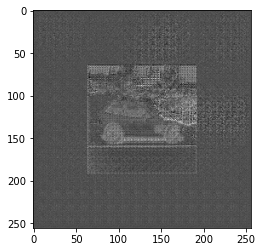

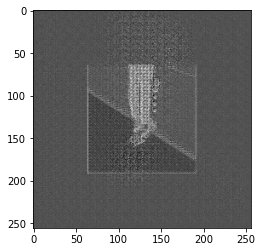

0

In [181]:
train_Gm(Gm, optimizer, dataloader, dataloader_test,\
         ic_dark_train_list, ic_dark_test_list,\
         mask_train_list, mask_test_list, epochs=1, device=device)

# Get ~Ig

In [143]:
mask_train_list = list(dataloader_mask_train)
mask_test_list = list(dataloader_mask_test)

In [164]:
# get Ig
def get_ig(Ic, Ic_dark, mask):
    ## reshape
    Ic_dark = Ic_dark.permute(1,2,0)
    mask = mask.permute(1,2,0)
    
    
    Ig = (Ic * (1-mask)) + (Ic_dark * mask) #eqtn. 7
    
    return Ig
    

In [169]:
ic_dark_path = 'DESOBA_DATASET/~Ig'

for i, data in enumerate(dataloader, 0): 
    if i == 1000:
        break
            
    ### fixing input size and shape
    object_pair = data[0].permute(1, 2, 0)
    original_img, Ic, Mfo, Mbos, Mfo_shadow = input_sectioning(object_pair)
    Ig = get_ig(Ic, ic_dark_train_list[i].squeeze(), mask_train_list[i].squeeze())
    
    # save Ig to folder
    Ig_normalized = (Ig.cpu().detach().numpy() * 255).astype(np.uint8)
    image = Image.fromarray(Ig_normalized)
    image.save(f'DESOBA_DATASET/~Ig/{i:04d}.png')
print('Done!')

Done!
